<a href="https://colab.research.google.com/github/OlgaTihanovich/DataScience/blob/main/HomeWork3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

#загрузка файла
df=pd.read_csv('/content/Coffe_sales.csv')

# Просматриваем первые несколько строк датасета
print(df.head())

# Получаем общую информацию о датасете
print(df.info())

# Выводим статистические данные о числовых столбцах
print(df.describe())

print(df.select_dtypes(include='object').describe())

#расчет количества уникальных значений
unique_values=df.nunique()
print(f"Количество уникальных значений\n {unique_values}")

#подсчитаем дубликаты
total_duplicates = df.duplicated().sum()
print(f"Количество полностью совпадающих строк: {total_duplicates}")


   hour_of_day cash_type  money    coffee_name Time_of_Day Weekday Month_name  \
0           10      card   38.7          Latte     Morning     Fri        Mar   
1           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3           13      card   28.9      Americano   Afternoon     Fri        Mar   
4           13      card   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort        Date             Time  
0            5          3  2024-03-01  10:15:50.520000  
1            5          3  2024-03-01  12:19:22.539000  
2            5          3  2024-03-01  12:20:18.089000  
3            5          3  2024-03-01  13:46:33.006000  
4            5          3  2024-03-01  13:48:14.626000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       ----

In [2]:
# Подключение к SQLite базе данных (или создание, если не существует)
import sqlite3
# Создаём соединение один раз
conn = sqlite3.connect('coffee.db', timeout = 10)

# Сохраняем DataFrame в SQLite
df.to_sql('coffee_sales_table', conn, if_exists='replace', index=False)

# Чтение первых 10 строк через fetchmany
cursor = conn.cursor()
cursor.execute("SELECT * FROM coffee_sales_table")
coffee_sales = cursor.fetchmany(10)
for data_coffee in coffee_sales:
    print(data_coffee)

# оценка  выручки по месяцам за 2024 год для Latte
print("\nОценка выручки за 2024 год для Latte")
sql_txt ="""SELECT a.month_name,
                   min(a.money) min_sale,
                   max(a.money) max_sale,
                   round(sum(a.money),2) sum_month,
                   round(sum(sum(a.money)) over (),2) sum_all,
                   round(avg(a.money),2) avg_sum,
                   coalesce(round(sum(a.money)/sum(sum(a.money)) over ()*100,2),0) proc_sale
             FROM coffee_sales_table a
             WHERE substr(a.date,1,4)='2024'
             AND a.coffee_name='Latte'
             GROUP BY a.month_name
             ORDER BY a.monthsort"""
cursor = conn.cursor()
cursor.execute(sql_txt)
coffee_sales=cursor.fetchall()
for data_coffee in coffee_sales:
    print(data_coffee)


# расчет количества и выручки по видам кофе за одну дату
print("\nРасчет количества и выручки по видам кофе 2024-03-01")
sql_txt ="""SELECT a.coffee_name,
                   count(*) kol_sales,
                   round(sum(a.money),2) sum_sale
             FROM coffee_sales_table a
             WHERE a.date='2024-03-01'
             GROUP BY a.coffee_name
             ORDER BY a.coffee_name"""
cursor = conn.cursor()
cursor.execute(sql_txt)
coffee_sales=cursor.fetchall()
for data_coffee in coffee_sales:
    print(data_coffee)


(10, 'card', 38.7, 'Latte', 'Morning', 'Fri', 'Mar', 5, 3, '2024-03-01', '10:15:50.520000')
(12, 'card', 38.7, 'Hot Chocolate', 'Afternoon', 'Fri', 'Mar', 5, 3, '2024-03-01', '12:19:22.539000')
(12, 'card', 38.7, 'Hot Chocolate', 'Afternoon', 'Fri', 'Mar', 5, 3, '2024-03-01', '12:20:18.089000')
(13, 'card', 28.9, 'Americano', 'Afternoon', 'Fri', 'Mar', 5, 3, '2024-03-01', '13:46:33.006000')
(13, 'card', 38.7, 'Latte', 'Afternoon', 'Fri', 'Mar', 5, 3, '2024-03-01', '13:48:14.626000')
(15, 'card', 33.8, 'Americano with Milk', 'Afternoon', 'Fri', 'Mar', 5, 3, '2024-03-01', '15:39:47.726000')
(16, 'card', 38.7, 'Hot Chocolate', 'Afternoon', 'Fri', 'Mar', 5, 3, '2024-03-01', '16:19:02.756000')
(18, 'card', 33.8, 'Americano with Milk', 'Night', 'Fri', 'Mar', 5, 3, '2024-03-01', '18:39:03.580000')
(19, 'card', 38.7, 'Cocoa', 'Night', 'Fri', 'Mar', 5, 3, '2024-03-01', '19:22:01.762000')
(19, 'card', 33.8, 'Americano with Milk', 'Night', 'Fri', 'Mar', 5, 3, '2024-03-01', '19:23:15.887000')

Оце

/tmp/ipython-input-1923717548.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_set, y='coffee_name', order=df_set['coffee_name'].value_counts().index, palette="rocket")


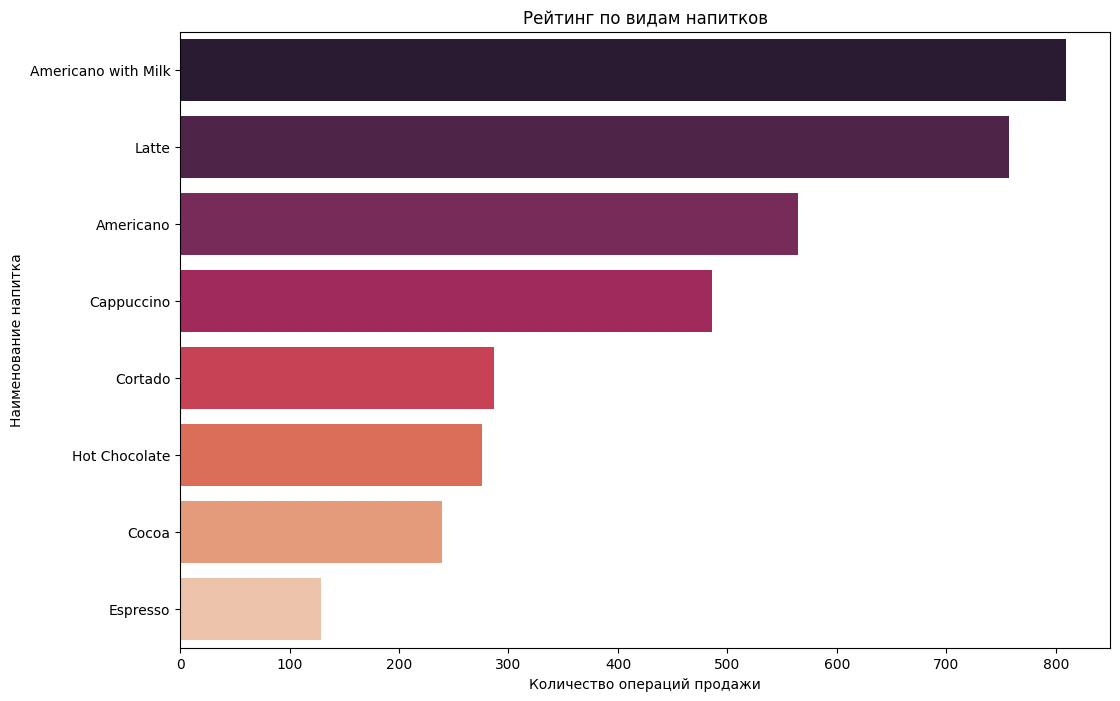

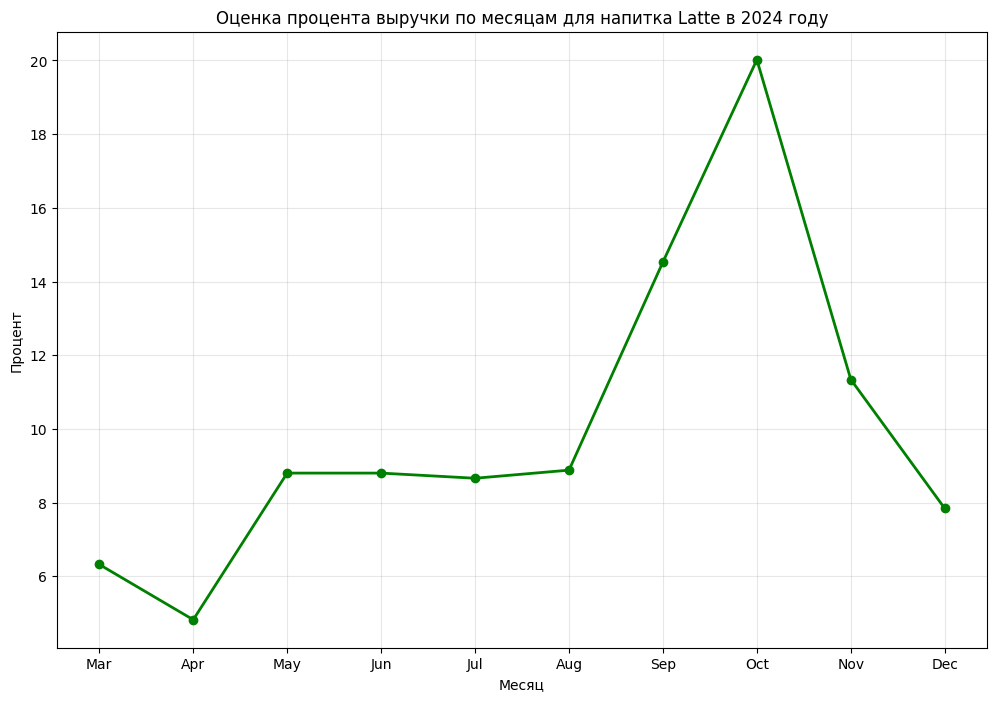

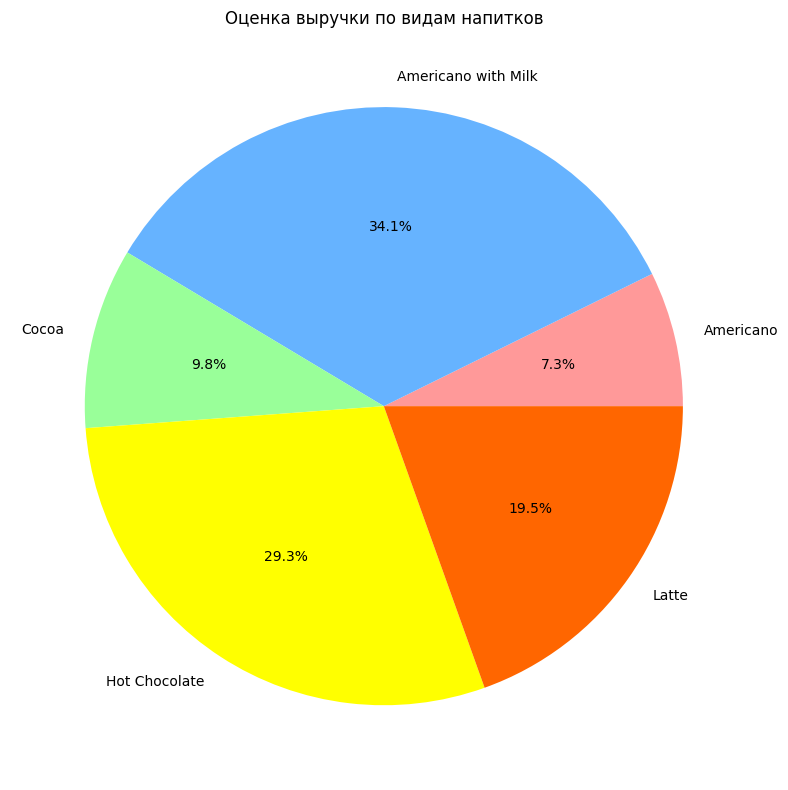

In [30]:
#визуализация
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Создаём соединение один раз
conn = sqlite3.connect('coffee.db', timeout = 10)
#cursor = conn.cursor()

#Количество операций продажи по месяцам
sql_txt = "SELECT * FROM coffee_sales_table"

df_set = pd.read_sql(sql_txt,conn)

plt.figure(figsize=(12,8))
sns.countplot(data=df_set, y='coffee_name', order=df_set['coffee_name'].value_counts().index, palette="rocket")
plt.title('Рейтинг по видам напитков')
plt.xlabel('Количество операций продажи')
plt.ylabel('Наименование напитка')
plt.show()

# оценка  выручки по месяцам за 2024 год для Latte
sql_txt_month ="""SELECT a.month_name month_name,
                   min(a.money) min_sale,
                   max(a.money) max_sale,
                   round(sum(a.money),2) sum_month,
                   round(sum(sum(a.money)) over (),2) sum_all,
                   round(avg(a.money),2) avg_sum,
                   coalesce(round(sum(a.money)/sum(sum(a.money)) over ()*100,2),0) proc_sale
             FROM coffee_sales_table a
             WHERE substr(a.date,1,4)='2024'
             AND a.coffee_name='Latte'
             GROUP BY a.month_name
             ORDER BY a.monthsort"""

df_set = pd.read_sql(sql_txt_month,conn)

plt.figure(figsize=(12,8))
plt.plot(df_set['month_name'], df_set['proc_sale'], marker='o', linewidth=2, markersize=6, color='green')
plt.title('Оценка процента выручки по месяцам для напитка Latte в 2024 году')
plt.xlabel('Месяц')
plt.ylabel('Процент')
plt.grid(True,alpha=0.3)
plt.show()

# расчет количества операций и суммы выручки по видам кофе за одну дату

sql_txt_date ="""SELECT a.coffee_name coffee_name,
                        count(*) kol_sales,
                        round(sum(a.money),2) sum_sale
                  FROM coffee_sales_table a
                  WHERE a.date='2024-03-01'
                  GROUP BY a.coffee_name
                  ORDER BY a.coffee_name"""

df_set = pd.read_sql(sql_txt_date,conn)

plt.figure(figsize=(12,8))
plt.pie(df_set['sum_sale'], labels= df_set['coffee_name'],autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff','#99ff99','#ffff00','#ff6600'])
plt.title('Оценка выручки по видам напитков за день')
plt.tight_layout()
plt.show()

# Закрываем курсор и соединение
cursor.close()
conn.close()